# Week 5. Preprocessing full train data (optional)
14.2.2019, Sakari Lukkarinen
[Helsinki Metropolia University of Applied Sciences](www.metropolia.fi/en)

## Background and Objectives

The aims of this Notebook are:
- to explain how to download the full dataset for [Diabetic rethinopathy detection](https://www.kaggle.com/c/diabetic-retinopathy-detection) Kaggle competition
- to show how to preprocess the trainset based on the winning solution
- to clean the dataset from corrupted images

## Download the full dataset

The easiest way to download the full dataset may be to use kaggle API. Notice that the full dataset is large: 82 GB!!! You need to have enough room in your computer and patience to wait the data is downloaded from the site.

1. First create an account for kaggle (https://www.kaggle.com)
2. Then go to the **Your Profile -> My Account** and select **Create API Token**.
3. Download the ´kaggle.json´ token and store it to folder 
    - (Linux, Mac) ´~/.kaggle/kaggle.json´
    - (Windows) ´C:/Users/username/.kaggle/kaggle.json´.
4. Install kaggle API using command prompt: **`pip install kaggle`**.
5. In command prompt, change the working directory (e.g. cd subdirectory) where your Case 2 Notebooks are.
6. Run the command: **`kaggle competitions download -c diabetic-retinopathy-detection`**.
7. Wait patiently until the full dataset is downloaded to your computer.

For more details, check [Kaggle API](https://github.com/Kaggle/kaggle-api) (scroll down for details).

## Extract the multi-zip files

It is recommended to use 7zip to extract the multi-zip files. See the [short Discussion](https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/45994) and [quick instructions](https://mintywhite.com/vista/extract-multipart-archives-000-001-r01-r02-7zip/). WinZip or WinRAR should also handle multi-zips, see this [post](https://www.techwalla.com/articles/how-to-extract-multi-part-zip-files).

Alternatively you can merge the files and use unzip normally:
- In Linux give the following commands:
```
cat train.zip.* > ~/train.zip
unzip train.zip
```
- In Windows
```
copy /B train.zip.* train.zip
unzip train.zip
```

For more details, see [How do I reassemble a zip file that has been emailed in multiple parts?](https://superuser.com/questions/15935/how-do-i-reassemble-a-zip-file-that-has-been-emailed-in-multiple-parts#15940)

## Preprocess the train dataset
The preprocessing is based on Benjamin Graham's [Competition report](https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/15801) where he explains the details how he won the [Diabetic rethinopathy detection](https://www.kaggle.com/c/diabetic-retinopathy-detection) Kaggle competition.

In his report he explains that he used the following preprocessing strategy:
1. Rescale the images to have the same radius (scale = 300 pixels).
2. Subtract the local average color from the images (50% gray).
3. Mask the image to 90% of the scale to remove the boundary effects.

In addition, he provided a Python code to do those steps. 

This Notebook replicates these preprocessing steps. 

NOTE! Before you can use this code, you need to download the full Kaggle competition training set and extract the image files to 'train' sub-folder as explained earlier.

In [62]:
# Import the libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob, cv2

### Rescale image based on fundus radius

In [63]:
def scaleRadius(img, scale):
    y0 = int(img.shape[0]/2)
    x = img[y0,:, :].sum(1)
    r = (x > x.mean()/10).sum()/2
    s = scale*1.0/r
    img = cv2.resize(img, (0, 0), fx = s, fy = s)
    return img

### Subtract the average color using opencv filtering tools

In [64]:
def subAverageColor(img, scale):
    blur = cv2.GaussianBlur(img, (0, 0), scale/30)
    img = cv2.addWeighted(img, 4, blur, -4, 128)
    return img

### Remove the boundary effects using circular mask

In [65]:
def removeBoundaries(img, scale):
    # Define the circular mask
    mask = np.zeros(img.shape)
    x0 = int(img.shape[1]/2)
    y0 = int(img.shape[0]/2)
    r0 = int(scale*0.9)
    cv2.circle(mask, (x0, y0), r0, (1, 1, 1), -1, 8, 0)
    
    # Apply the mask to the image
    img = img*mask
    img = img + 128*(1 - mask)
    img = img.astype(int)
    
    return img

### Testing the functions

The following code cells test if the preprocessing functions work properly.

#### Test - read the orignal image

Pixel (min, max): 0 255


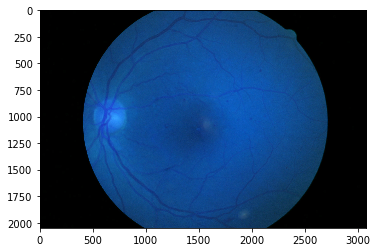

In [72]:
scale = 300

f = '/media/sakari/Transcend/Retinopathy/300_test/25313_left.jpeg'
f = '/media/sakari/Transcend/Retinopathy/test/27096_left.jpeg'
#f = 'train/38245_right.jpeg'
a = cv2.imread(f)
print('Pixel (min, max):', np.min(a), np.max(a))
plt.imshow(a)
plt.show()

#### Test - Resize the image

Pixel (min, max): 0 255


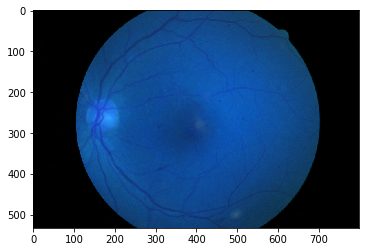

In [73]:
b = scaleRadius(a, scale)
print('Pixel (min, max):', np.min(b), np.max(b))
plt.imshow(b)
plt.show()

#### TEst - Subtract the average color

Pixel (min, max): 0 255


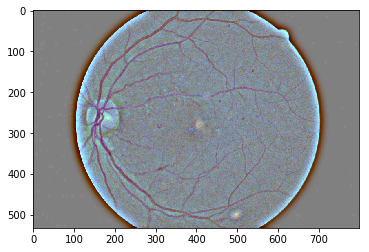

In [74]:
c = subAverageColor(b, scale)
print('Pixel (min, max):', np.min(c), np.max(c))
plt.imshow(c)
plt.show()

#### Test - Clear the pixels outside 90% of the radius

Pixel (min, max): 12 255


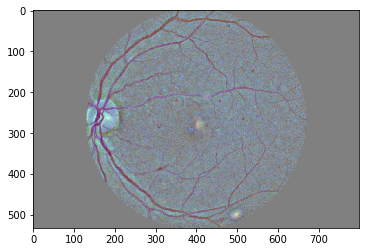

In [75]:
d = removeBoundaries(c, scale)
print('Pixel (min, max):', np.min(d), np.max(d))
plt.imshow(d)
plt.show()

In [57]:
# Shape of the image (height, width, colors)
d.shape

(575, 767, 3)

### Preprocess original train images

NOTE: This takes a LONG time !!!

This code requires that:
- the original images are in subfolder: train
- you have manually created a subfolder: 300_train

The code prints the image files that can't be preprocessed. They need to be handled manually. 

In [85]:
scale = 300

for f in glob.glob('train/*.jpeg'):
    try:
        a = cv2.imread(f)
        a = scaleRadius(a, scale)
        a = subAverageColor(a, scale)
        a = removeBoundaries(a, scale)
        cv2.imwrite(str(scale) + '_' + f, a)
    except:
        print(f)

/home/sakari/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


train/492_right.jpeg


Seems that both right and left eye images of ID 492 are corrupted

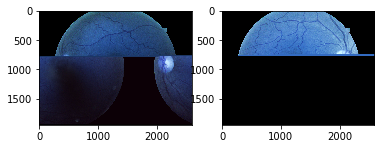

In [26]:
f = 'train/492_left.jpeg'
a = cv2.imread(f)
plt.subplot(1,2,1)
plt.imshow(a)

f = 'train/492_right.jpeg'
a = cv2.imread(f)
plt.subplot(1,2,2)
plt.imshow(a)
plt.show()

In [17]:
# Check the total size of the new directory

new_train_dir = '300_train'
extension = '.jpeg'

s = []
for f in glob.glob('300_train/*.jpeg'):
    file_size = os.path.getsize(f)
    s.append(file_size/1.0e6) # size in megabytes
s = np.array(s)
print('Total: {:.2f} GB'.format(sum(s)/1000))

Total: 4.90 GB


### Clean up the dataframe

- the original train labels are read in
- the corrupted images are dropped from the list and
- a new list of images, labels and image sizes (n MB) is saved to new csv-file


In [48]:
# Read the original trainLabels file
filename = 'trainLabels.csv'
df = pd.read_csv(filename)

# Manually drop the corrupted images from the list
c_list = ['492_left', '492_right']
for image in c_list:
    i = df.loc[df['image'] == image].index
    df.drop(i, inplace =  True)

# Get the size of the images 
new_train_dir = '300_train'
s =  []
for file in df['image']:
    full_name = os.path.join(new_train_dir, file + extension)
    file_size = os.path.getsize(full_name)
    s.append(file_size/1.0e6) # file size in MB
df['MB'] = pd.Series(s, index = df.index)

# Print the head and tail of the new list and total size of the train set
print(df.head())
print('')
print(df.tail())
print('')
print('Total {:.2f} MB'.format(df['MB'].sum()))

# Write the new list to csv-file
new_file = 'newTrainLabels.csv'
df.to_csv(new_file, index = False)

print('')
print('Labels saved to:', new_file)

      image  level        MB
0   10_left      0  0.146893
1  10_right      0  0.134647
2   13_left      0  0.179653
3  13_right      0  0.173361
4   15_left      1  0.129906

             image  level        MB
35121  44347_right      0  0.149623
35122   44348_left      0  0.113455
35123  44348_right      0  0.126852
35124   44349_left      0  0.148058
35125  44349_right      1  0.140587

Total 4902.91 MB

Labels saved to: newTrainLabels.csv


In [59]:
# Check the new train labes file
df2 = pd.read_csv(new_file)
print(df2.tail())

             image  level        MB
35119  44347_right      0  0.149623
35120   44348_left      0  0.113455
35121  44348_right      0  0.126852
35122   44349_left      0  0.148058
35123  44349_right      1  0.140587


Notice that the corrupted image names are dropped out from the file 

## Conclusion

This Notebook was used to preprocess the original Diabetic Retinopathy Disease Kaggle competion train dataset. Similarly you could use it to preprocess the test dataset, or modify the code to make your own preprocessing scheme.

The preprocessed dataset is provided in this Kaggle environment.